# Asymmetry test series

For the paper, for each measurement, generate plots of how the asymmetry measurement depends on 
1) Signal-to-noise
2) Pixel scale
3) PSF FWHM

Keeping all other parameters constant. For constant values, choose:

* Pixel scale: 0.1" (about 180pc at z=0.1, 300pc at z=0.2)
* PSF FWHM: 0.8" (good ground-based seeing)
* Noise level: 25 mag/arcsec$^2$ (pretty deep imaging)


#### Imports

In [16]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from galaxy_generator import get_galaxy_rng_vals, get_augmentation_rng_vals, simulate_perfect_galaxy, add_source_to_image, sky_noise
from asymmetry import get_asymmetry, fourier_deconvolve
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma

seed = 19
perfect_pxscale = 0.1
convolve_nyquist = True

## Generating a galaxy

We use a single galaxy for all the plots here, generated with the same set of parameters. 

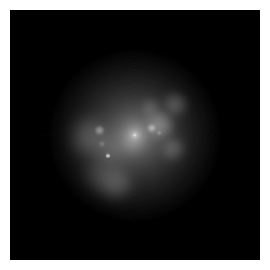

In [2]:
params = get_galaxy_rng_vals(1, perfect_pxscale=perfect_pxscale, seed=seed)[0]
img_perfect, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=perfect_pxscale,  **params)

plt.imshow(-2.5*np.log10(img_perfect/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
plt.axis('off');

In [62]:
def augment(pxscale, psf_fwhm, sky_mag):
    
    img_lowres, out_dict, r_pet = simulate_perfect_galaxy(pxscale=pxscale, **params)
    img_psf = add_source_to_image(**out_dict, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method='astropy')
    img_noisy, sky_flux = sky_noise(img_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)
    return img_noisy, img_lowres

In [64]:
# plt.imshow(-2.5*np.log10(img_noisy/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

Test deconvolution:

In [81]:
from numpy import fft
from asymmetry import _fit_snr

def fourier_deconvolve2(img, psf, noise, pxscale, convolve_nyquist=False):

    # img = np.pad(img, (20,20))
    # psf = np.pad(psf, (20,20))

    # Transform the image and the PSF
    img_fft = fft.fft2(img)
    psf_fft = fft.fft2(fft.ifftshift(psf))
    noise_fft = noise * img_fft.shape[0] 

    # Get the SNR
    snr = _fit_snr(img_fft, noise_fft)

    # If True, convolve down to Nyquist frequency
    if convolve_nyquist:
        nyquist_psf = Gaussian2DKernel(2*gaussian_fwhm_to_sigma, x_size=img.shape[1], y_size=img.shape[0])
        nyquist_fft = fft.fft2(fft.ifftshift(nyquist_psf))
    else:
        nyquist_fft = 1
        
    # Deconvolve
    H_sq = np.power((1 + 1/snr), 2) / np.power((np.abs(psf_fft) + 1/snr), 2)
    H = np.sqrt(H_sq)
    
    H = (nyquist_fft + 1/snr) / (psf_fft + 1/snr)
    img_corr = img_fft * H

    # Do an inverse transform
    img_deconv = np.real(fft.ifft2(img_corr))

    # img_deconv = img_deconv[20:-20, 20:-20]
    return img_deconv

In [82]:
pxscale = 0.2
psf_fwhm = 2
sky_mag = 22.5

img_noisy, img_lowres = augment(pxscale, psf_fwhm, sky_mag)
# psf_nyquiest = Gaussian2DKernel(
psf = Gaussian2DKernel(psf_fwhm*gaussian_fwhm_to_sigma/pxscale, x_size=img_noisy.shape[1], y_size=img_noisy.shape[0])
_, bgsd, _ = sigma_clipped_stats(img_noisy, sigma=2)

img_deconv = fourier_deconvolve2(img_noisy, psf, bgsd, 0.3, True)

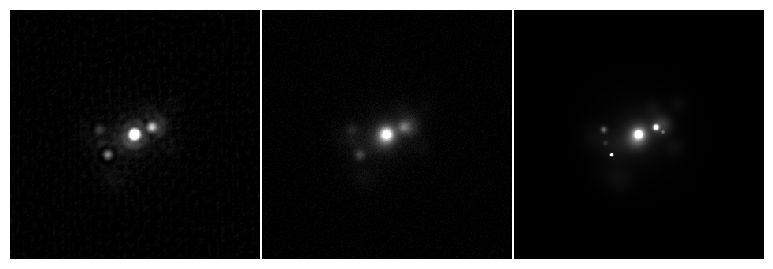

In [79]:
fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

axs[0].imshow(((img_deconv)/pxscale**2), vmin=0, vmax=1e5, cmap='gray')
axs[1].imshow(((img_noisy)/pxscale**2), vmin=0, vmax=1e5, cmap='gray')
axs[2].imshow(((img_lowres)/pxscale**2) , vmin=0, vmax=1e5, cmap='gray')

for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.01)

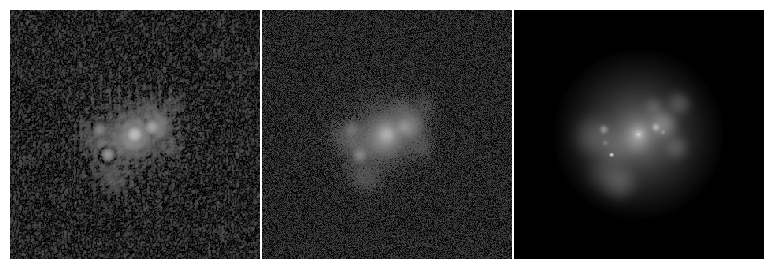

In [80]:
fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

axs[0].imshow(-2.5*np.log10(np.abs(img_deconv)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(img_noisy)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[2].imshow(-2.5*np.log10(np.abs(img_lowres)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.01)

## Calculating asymmetry

Calculate 4 different asymmetry measurements:

* CAS |A|
* Corrected CAS |A|
* $A^2$
* Fourier $A^2$

For a given galaxy

In [5]:
def get_asymmetry_measurements(img_real, img_obs, pxscale, psf, bgsd):
    
    #### Calculate real galaxy asymmertry
    a_cas_real = get_asymmetry(img_real, ap_frac*r_pet/perfect_pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_sq_real = get_asymmetry(img_real, ap_frac*r_pet/perfect_pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
    
    #### Calculate noisy asymmetries
    a_cas, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_cas_corr, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_sq, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
    
    # Fourier asymmetry
    # Estimate background noise
    img_deconv = fourier_deconvolve(img_obs, psf, bgsd, convolve_nyquist=convolve_nyquist)
    a_fourier, _ = get_asymmetry(img_deconv, ap_frac*r_pet/pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
 
    ##### Store output
    output = {
        'a_cas_real' : a_cas_real, 'a_sq_real' : a_sq_real, 
        'a_cas' : a_cas, 'a_cas_cor' : a_cas_corr, 
        'a_sq' : a_sq, 'a_fourier' : a_fourier
    }
    
    return output, img_deconv
    

## CAS asymmetry

We use the same set-up as for all other tests, but for these test series, only test on a single galaxy. Make a realization with one seed so we know it's always the same if the kernel is refreshed.

In [9]:
rng = np.random.default_rng(seed=0)

In [14]:
rng.uniform(low=[0,1], high=[1,2], size=3)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).